# Modélisation

### Import des modules

In [17]:
import importlib
import sys, os
import warnings

from sklearn.exceptions import UndefinedMetricWarning

sys.path.append(os.path.abspath(".."))
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import joblib
import utils.scoring as scoring_mod

from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline

importlib.reload(scoring_mod)

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc

from sklearn.model_selection import StratifiedKFold

results = []



### Encodage / Validation des donneés

In [18]:
df = joblib.load("df.joblib")

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1407 entries, 0 to 1469
Data columns (total 37 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   age                                        1407 non-null   int64   
 1   genre                                      1407 non-null   object  
 2   revenu_mensuel                             1407 non-null   int64   
 3   statut_marital                             1407 non-null   object  
 4   departement                                1407 non-null   object  
 5   poste                                      1407 non-null   object  
 6   nombre_experiences_precedentes             1407 non-null   int64   
 7   annee_experience_totale                    1407 non-null   int64   
 8   annees_dans_l_entreprise                   1407 non-null   int64   
 9   annees_dans_le_poste_actuel                1407 non-null   int64   
 10  a_quitte_l_entrep

In [19]:

cat_cols = [
    'genre',
    'statut_marital',
    'departement',
    'poste',
    'domaine_etude',
    'frequence_deplacement',
    'heure_supplementaires',
    'tranche_age',
    'tranche_revenu',
    'tranche_distance',
    'tranche_sat_mean'
]

num_cols = [
    'niveau_education',
    'nombre_experiences_precedentes',
    'augementation_salaire_precedente',
    'annee_experience_totale',
    'annees_dans_l_entreprise',
    'annees_dans_le_poste_actuel',
    'nombre_participation_pee',
    'nb_formations_suivies',
    'annees_depuis_la_derniere_promotion',
    'annes_sous_responsable_actuel',
    'note_evaluation_precedente',
    'note_evaluation_actuelle',
    'satisfaction_employee_environnement',
    'satisfaction_employee_nature_travail',
    'satisfaction_employee_equipe',
    'satisfaction_employee_equilibre_pro_perso',
    'niveau_hierarchique_poste',
    #Feature Engineering
    "sat_mean",
    "sat_std",
    "delta_eval",
    "revenu_par_niveau",
    "ratio_post_stab"
]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)


In [20]:
# Drop la target a_quitte_l_entreprise
X = df.drop(columns=["a_quitte_l_entreprise"])

# Valeurs de la target
y = df.loc[X.index, "a_quitte_l_entreprise"]

In [21]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,  stratify=y     
)

### Dummy Classifier

In [22]:
model = DummyClassifier(strategy='most_frequent')

pipe = SkPipeline([
    ('preprocessing', preprocessor),
    ('classifier', model)
])

pipe.fit(X_train, y_train)

results.append(scoring_mod.score_classification("DummyClassifier", pipe, X, y))

📊 Model: DummyClassifier
→ Accuracy      | Train: 0.836 | Test: 0.836
→ Precision     | Train: 0.000 | Test: 0.000
→ Recall        | Train: 0.000 | Test: 0.000
→ F1-score      | Train: 0.000 | Test: 0.000
→ ROC-AUC-score | Train: 0.500 | Test: 0.500
→ PR-AUC-score  | Train: 0.164 | Test: 0.164
→ Train Time: 9.22 ms
→ Predict Time: 10.24 ms


### Logistic Regression

In [23]:
pipe_lr_vanilla = SkPipeline([
    ('preprocessing', preprocessor),
    ('clf', LogisticRegression(random_state=42, max_iter=5000, solver='saga', penalty='l2')) 
])

results.append(
    scoring_mod.score_classification("LogisticRegression (no SMOTE)", pipe_lr_vanilla, X, y)
)

📊 Model: LogisticRegression (no SMOTE)
→ Accuracy      | Train: 0.904 | Test: 0.889
→ Precision     | Train: 0.835 | Test: 0.757
→ Recall        | Train: 0.521 | Test: 0.476
→ F1-score      | Train: 0.641 | Test: 0.583
→ ROC-AUC-score | Train: 0.750 | Test: 0.723
→ PR-AUC-score  | Train: 0.514 | Test: 0.450
→ Train Time: 147.81 ms
→ Predict Time: 10.74 ms


In [24]:
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score


pipe_smote_lr = ImbPipeline([
    ('preprocessing', preprocessor),   
    ('smote', SMOTE(random_state=42, k_neighbors=5, sampling_strategy=0.75)),
    ('clf', LogisticRegression(
        random_state=42,
        solver='saga',       
        penalty='l2',
        max_iter=5000,
    ))
])

param_grid = {
    'smote__k_neighbors': [3, 5, 7],
    'smote__sampling_strategy': [0.5, 0.75, 1.0],
    'clf__C': [0.01, 0.1, 1, 3]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'pr_auc':  'average_precision', 
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall':    make_scorer(recall_score, zero_division=0),
    'f1':        make_scorer(f1_score, zero_division=0),
}

gs_lr = GridSearchCV(
    estimator=pipe_smote_lr,
    param_grid=param_grid,
    scoring=scoring,
    refit='pr_auc',  
    cv=cv,
)

gs_lr.fit(X_train, y_train)

best_lr = gs_lr.best_estimator_

results.append(
    scoring_mod.score_classification("LogisticRegression (SMOTE + Grid)", best_lr, X, y)
)

📊 Model: LogisticRegression (SMOTE + Grid)
→ Accuracy      | Train: 0.877 | Test: 0.861
→ Precision     | Train: 0.618 | Test: 0.573
→ Recall        | Train: 0.659 | Test: 0.619
→ F1-score      | Train: 0.638 | Test: 0.593
→ ROC-AUC-score | Train: 0.789 | Test: 0.764
→ PR-AUC-score  | Train: 0.463 | Test: 0.417
→ Train Time: 75.60 ms
→ Predict Time: 11.03 ms


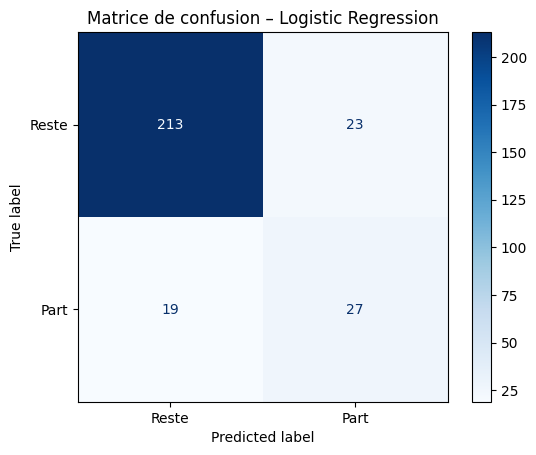

In [25]:

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


y_proba = best_lr.predict_proba(X_test)[:, 1]

prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_thr = thr[np.nanargmax(f1)]

y_pred_custom = (y_proba >= best_thr).astype(int)

cm = confusion_matrix(y_test, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Reste", "Part"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice de confusion – Logistic Regression")
plt.show()


### Random ForestClassifier

In [26]:
# Vanilla
from sklearn.preprocessing import MinMaxScaler


pipe_rf_vanilla = SkPipeline([
    ('preprocessing', preprocessor),
    ('clf', RandomForestClassifier(
        random_state=42,
        n_jobs=-1,        
        class_weight=None
    ))
])

results.append(
    scoring_mod.score_classification("RandomForest (no SMOTE)", pipe_rf_vanilla, X, y)
)

📊 Model: RandomForest (no SMOTE)
→ Accuracy      | Train: 1.000 | Test: 0.852
→ Precision     | Train: 1.000 | Test: 0.781
→ Recall        | Train: 1.000 | Test: 0.143
→ F1-score      | Train: 1.000 | Test: 0.233
→ ROC-AUC-score | Train: 1.000 | Test: 0.567
→ PR-AUC-score  | Train: 1.000 | Test: 0.256
→ Train Time: 205.52 ms
→ Predict Time: 52.72 ms


In [27]:

from sklearn.metrics import make_scorer


pipe_smote_rf = ImbPipeline([
    ('preprocessing', preprocessor), 
    ('smote', SMOTE(random_state=42, k_neighbors=5, sampling_strategy='auto')),
    ('clf', RandomForestClassifier(
        random_state=42,
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=2,
        min_samples_split=4,
        max_features='sqrt',
        n_jobs=-1,
        class_weight=None       
    ))
])

param_grid = {
    'smote__k_neighbors': [3, 5],
    'smote__sampling_strategy': [0.5, 0.75, 1.0], 
    'clf__n_estimators': [150, 400],
    'clf__min_samples_leaf': [1, 2],
    'clf__min_samples_split': [2, 4],
    'clf__max_depth': [None, 12, 16],
    'clf__max_features': ['sqrt']
}

scoring = {
    'pr_auc':  'average_precision', 
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall':    make_scorer(recall_score, zero_division=0),
    'f1':        make_scorer(f1_score, zero_division=0),
}


gs = GridSearchCV(
    pipe_smote_rf,
    param_grid=param_grid,
    scoring=scoring,
    refit='pr_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)

best_model = gs.best_estimator_

results.append(scoring_mod.score_classification("RandomForest (SMOTE + Grid)", best_model, X, y))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
📊 Model: RandomForest (SMOTE + Grid)
→ Accuracy      | Train: 0.999 | Test: 0.862
→ Precision     | Train: 1.000 | Test: 0.767
→ Recall        | Train: 0.997 | Test: 0.234
→ F1-score      | Train: 0.998 | Test: 0.355
→ ROC-AUC-score | Train: 0.998 | Test: 0.610
→ PR-AUC-score  | Train: 0.997 | Test: 0.308
→ Train Time: 299.93 ms
→ Predict Time: 67.21 ms


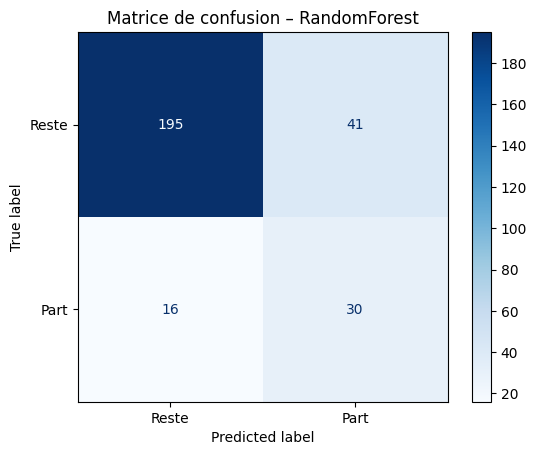

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

y_proba = best_model.predict_proba(X_test)[:, 1]

prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_thr = thr[np.nanargmax(f1)]

y_pred_custom = (y_proba >= best_thr).astype(int)

cm = confusion_matrix(y_test, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Reste", "Part"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice de confusion – RandomForest")
plt.show()


In [29]:
df_results = pd.DataFrame(results)

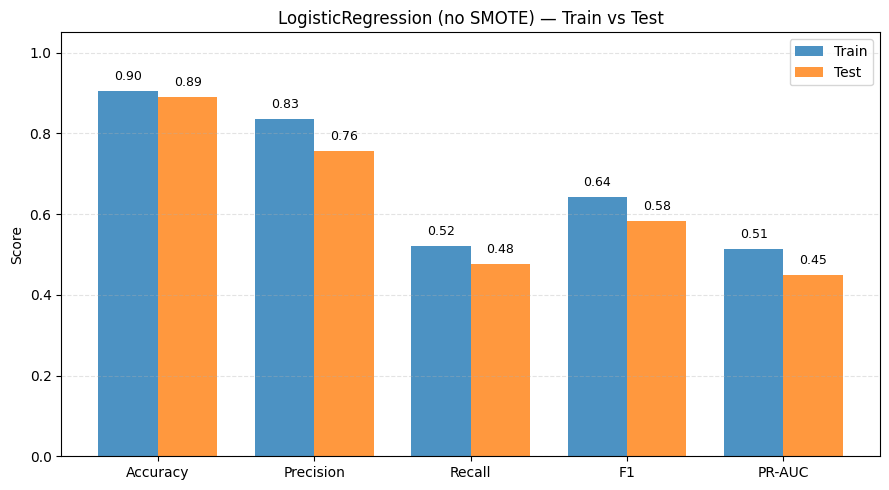

In [30]:
model_name = "LogisticRegression (no SMOTE)"

row = df_results[df_results["Model"] == model_name].iloc[0]
train = pd.Series(row["Train"])
test  = pd.Series(row["Test"])

metrics = ["Accuracy", "Precision", "Recall", "F1", "PR-AUC"]
x = np.arange(len(metrics)); bar_width = 0.38

plt.figure(figsize=(9,5))
b_train = plt.bar(x - bar_width/2, train[metrics].values, width=bar_width, label="Train", alpha=0.8)
b_test  = plt.bar(x + bar_width/2, test[metrics].values,  width=bar_width, label="Test",  alpha=0.8)

plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title(f"{model_name} — Train vs Test")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.35)

for b in list(b_train)+list(b_test):
    h = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, h+0.02, f"{h:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout(); plt.show()


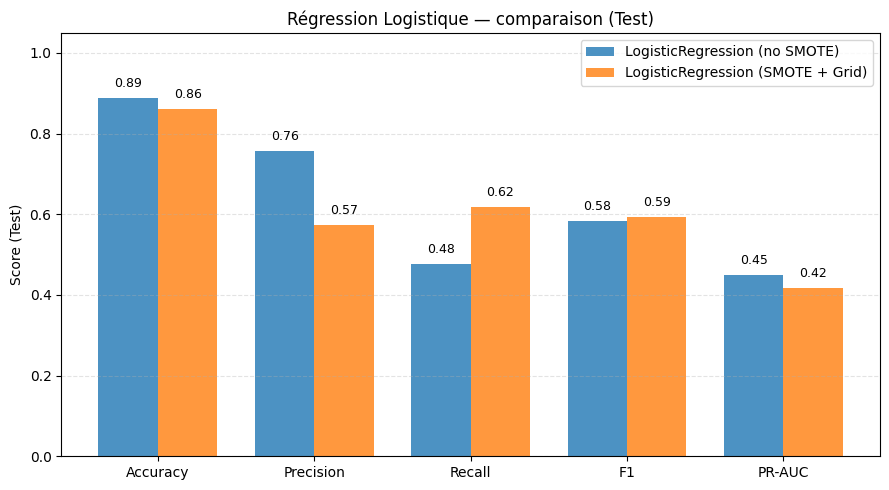

In [31]:
vanilla_name = "LogisticRegression (no SMOTE)"
smote_name   = "LogisticRegression (SMOTE + Grid)"

df_lr = df_results[df_results["Model"].isin([vanilla_name, smote_name])].copy()

df_test = pd.concat(
    [df_lr[["Model"]], df_lr["Test"].apply(pd.Series)],
    axis=1
)

df_test["order"] = df_test["Model"].map({vanilla_name: 0, smote_name: 1})
df_test = df_test.sort_values("order").drop(columns="order")

metrics = ["Accuracy", "Precision", "Recall", "F1", "PR-AUC"]
vals_vanilla = [df_test.loc[df_test["Model"] == vanilla_name, m].iloc[0] for m in metrics]
vals_smote   = [df_test.loc[df_test["Model"] == smote_name,   m].iloc[0] for m in metrics]

x = np.arange(len(metrics))
bar_width = 0.38

plt.figure(figsize=(9, 5))
bars_v = plt.bar(x - bar_width/2, vals_vanilla, width=bar_width, label=vanilla_name, alpha=0.8)
bars_s = plt.bar(x + bar_width/2, vals_smote,   width=bar_width, label=smote_name,   alpha=0.8)

plt.xticks(x, metrics)
plt.ylim(0, 1.05) 
plt.ylabel("Score (Test)")
plt.title("Régression Logistique — comparaison (Test)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.35)

def add_labels(bars):
    for b in bars:
        h = b.get_height()
        plt.text(b.get_x() + b.get_width()/2, h + 0.02, f"{h:.2f}",
                 ha='center', va='bottom', fontsize=9)
add_labels(bars_v)
add_labels(bars_s)

plt.tight_layout()
plt.show()


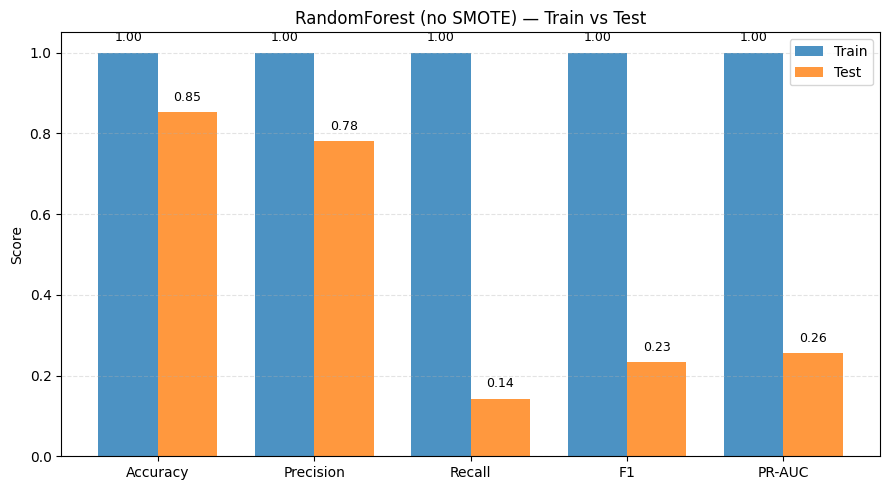

In [32]:
model_name = "RandomForest (no SMOTE)"

row = df_results[df_results["Model"] == model_name].iloc[0]
train = pd.Series(row["Train"])
test  = pd.Series(row["Test"])

metrics = ["Accuracy", "Precision", "Recall", "F1", "PR-AUC"]
x = np.arange(len(metrics)); bar_width = 0.38

plt.figure(figsize=(9,5))
b_train = plt.bar(x - bar_width/2, train[metrics].values, width=bar_width, label="Train", alpha=0.8)
b_test  = plt.bar(x + bar_width/2, test[metrics].values,  width=bar_width, label="Test",  alpha=0.8)

plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title(f"{model_name} — Train vs Test")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.35)

for b in list(b_train)+list(b_test):
    h = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, h+0.02, f"{h:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout(); plt.show()


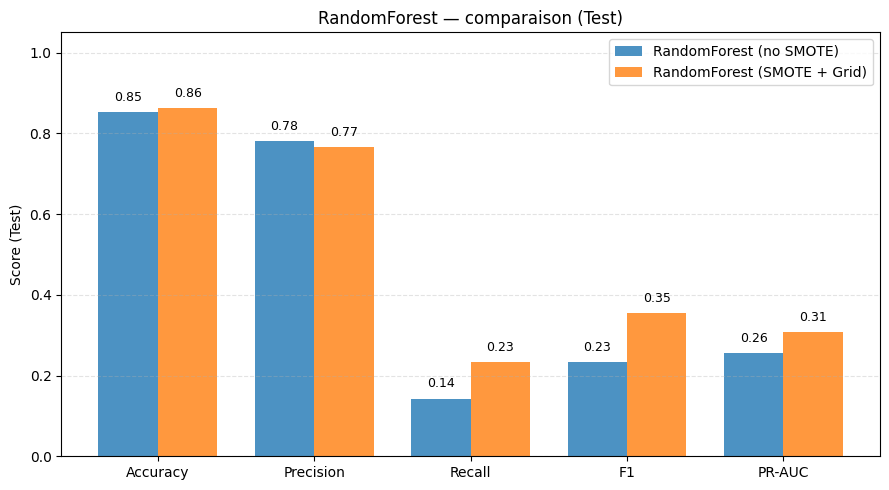

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

vanilla_name = "RandomForest (no SMOTE)"
smote_name   = "RandomForest (SMOTE + Grid)"

df_lr = df_results[df_results["Model"].isin([vanilla_name, smote_name])].copy()

df_test = pd.concat(
    [df_lr[["Model"]], df_lr["Test"].apply(pd.Series)],
    axis=1
)

df_test["order"] = df_test["Model"].map({vanilla_name: 0, smote_name: 1})
df_test = df_test.sort_values("order").drop(columns="order")

metrics = ["Accuracy", "Precision", "Recall", "F1", "PR-AUC"]
vals_vanilla = [df_test.loc[df_test["Model"] == vanilla_name, m].iloc[0] for m in metrics]
vals_smote   = [df_test.loc[df_test["Model"] == smote_name,   m].iloc[0] for m in metrics]

x = np.arange(len(metrics))
bar_width = 0.38

plt.figure(figsize=(9, 5))
bars_v = plt.bar(x - bar_width/2, vals_vanilla, width=bar_width, label=vanilla_name, alpha=0.8)
bars_s = plt.bar(x + bar_width/2, vals_smote,   width=bar_width, label=smote_name,   alpha=0.8)

plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.ylabel("Score (Test)")
plt.title("RandomForest — comparaison (Test)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.35)

def add_labels(bars):
    for b in bars:
        h = b.get_height()
        plt.text(b.get_x() + b.get_width()/2, h + 0.02, f"{h:.2f}",
                 ha='center', va='bottom', fontsize=9)
add_labels(bars_v)
add_labels(bars_s)

plt.tight_layout()
plt.show()


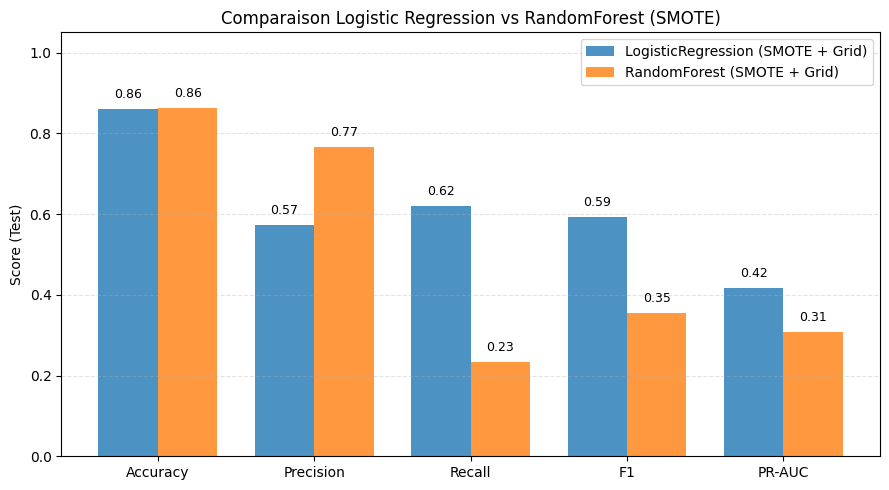

In [35]:
rf_name   = "RandomForest (SMOTE + Grid)"
lr_name   = "LogisticRegression (SMOTE + Grid)"

df_comp = df_results[df_results["Model"].isin([rf_name, lr_name])].copy()

df_test = pd.concat(
    [df_comp[["Model"]], df_comp["Test"].apply(pd.Series)],
    axis=1
)

df_test["order"] = df_test["Model"].map({lr_name: 0, rf_name: 1})
df_test = df_test.sort_values("order").drop(columns="order")

metrics = ["Accuracy", "Precision", "Recall", "F1", "PR-AUC"]
vals_lr = [df_test.loc[df_test["Model"] == lr_name, m].iloc[0] for m in metrics]
vals_rf = [df_test.loc[df_test["Model"] == rf_name,   m].iloc[0] for m in metrics]

x = np.arange(len(metrics))
bar_width = 0.38

plt.figure(figsize=(9, 5))
bars_lr = plt.bar(x - bar_width/2, vals_lr, width=bar_width, label=lr_name, alpha=0.8)
bars_rf = plt.bar(x + bar_width/2, vals_rf, width=bar_width, label=rf_name, alpha=0.8)

plt.xticks(x, metrics)
plt.ylim(0, 1.05) 
plt.ylabel("Score (Test)")
plt.title("Comparaison Logistic Regression vs RandomForest (SMOTE)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.35)

def add_labels(bars):
    for b in bars:
        h = b.get_height()
        plt.text(b.get_x() + b.get_width()/2, h + 0.02, f"{h:.2f}",
                 ha='center', va='bottom', fontsize=9)

add_labels(bars_lr)
add_labels(bars_rf)

plt.tight_layout()
plt.show()


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


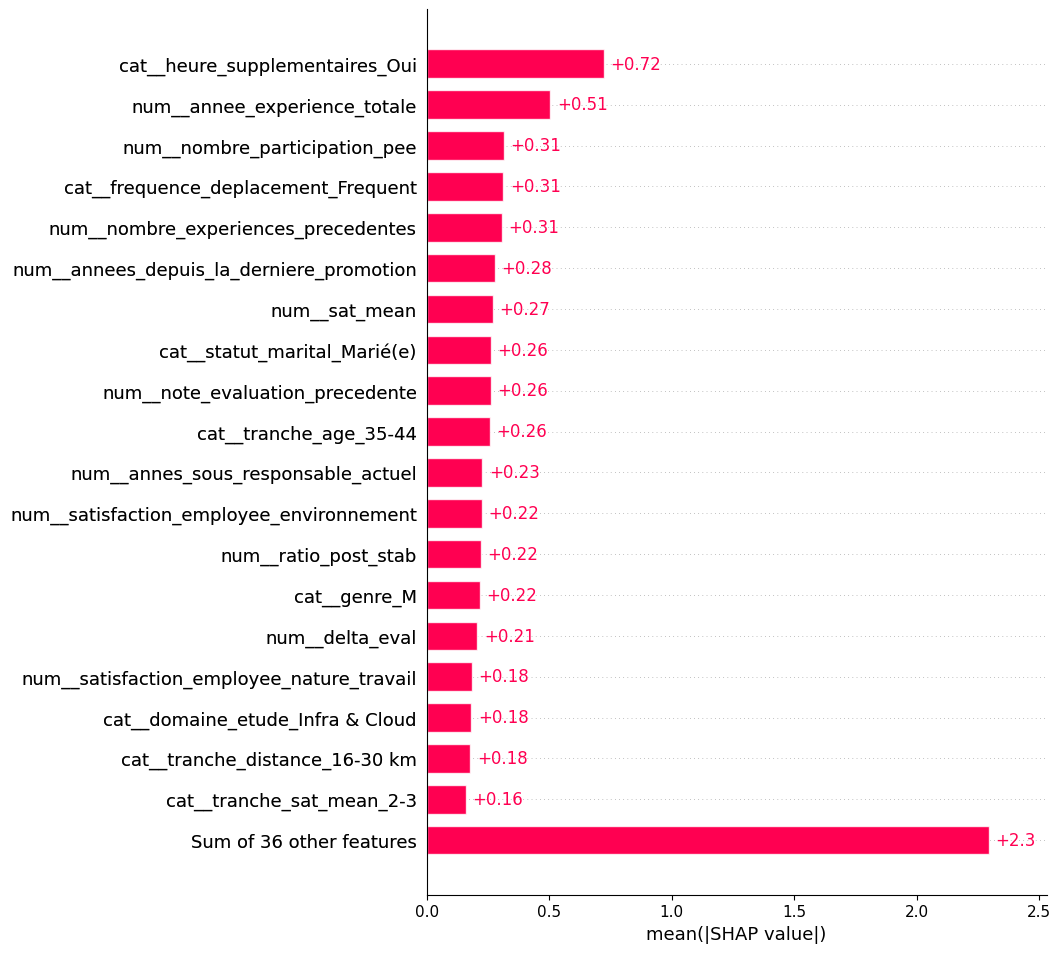

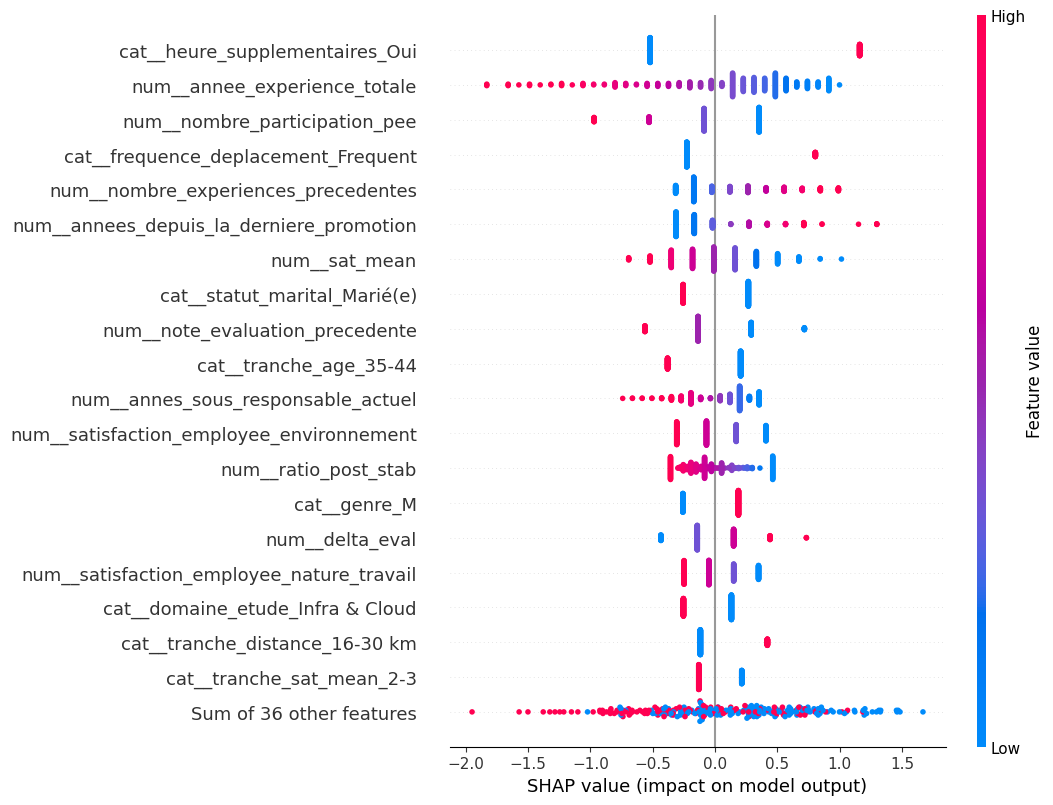

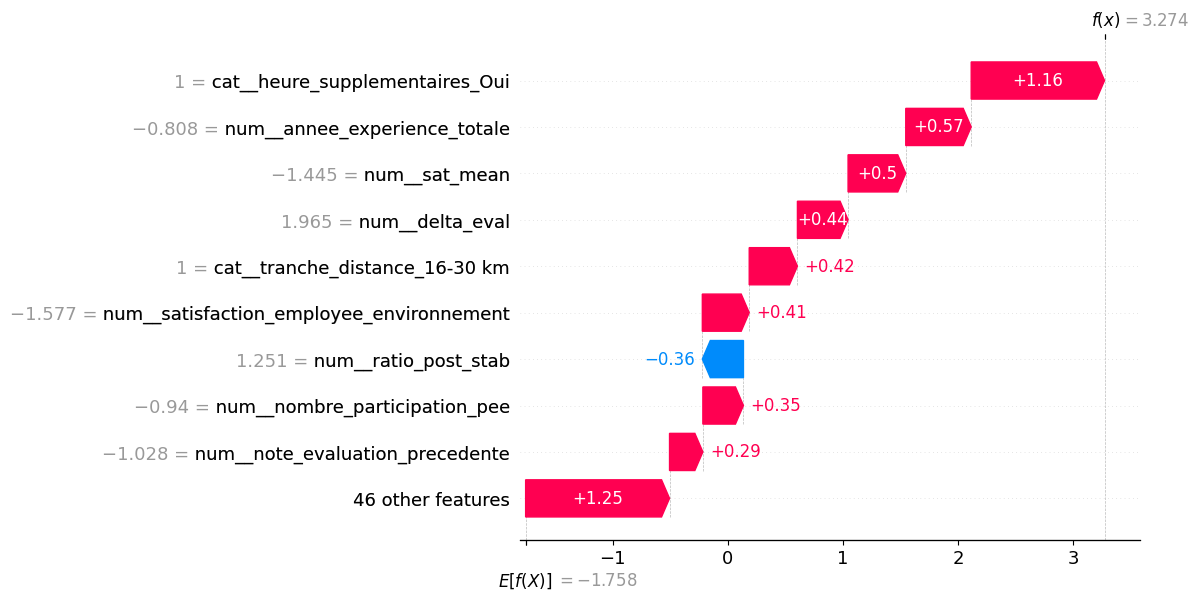

In [34]:
import shap
import pandas as pd
import numpy as np

best_pipe = gs_lr.best_estimator_
pre  = best_pipe.named_steps['preprocessing']
clf  = best_pipe.named_steps['clf']

Xtr = pre.transform(X_train)
Xte = pre.transform(X_test)
feat = pre.get_feature_names_out()

def to_df(X):
    return pd.DataFrame(X.toarray() if hasattr(X, "toarray") else X,
                        columns=feat)

Xtr_df, Xte_df = to_df(Xtr), to_df(Xte)

explainer = shap.LinearExplainer(clf, Xtr_df, link=shap.links.logit)
sv = explainer(Xte_df)   

mean_abs = pd.Series(
    np.abs(sv.values).mean(axis=0),
    index=feat
).sort_values(ascending=False)


shap.plots.bar(sv, max_display=20)      

shap.plots.beeswarm(sv, max_display=20)

proba = best_pipe.predict_proba(X_test)[:, 1] 

i = proba.argmax()

shap.plots.waterfall(sv[i], max_display=10)